In [1]:
import sys; print(sys.version)

3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]


In [2]:
!pip install --upgrade pip

^C


In [3]:
!pip install tensorflow

In [4]:
from IPython.display import clear_output
!pip install kaggle imutils plotly opencv-python matplotlib scikit-learn
clear_output()

In [42]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.vgg16 import VGG16, preprocess_input
# from keras import layers
# from keras.models import Model, Sequential
# from keras.optimizers import Adam, RMSprop
# from keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout


init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [44]:
import zipfile

# Download datasets
!kaggle datasets download -d gaborfodor/keras-pretrained-models
# !kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!kaggle datasets download -d abhranta/brain-tumor-detection-mri

# Unzip the datasets
with zipfile.ZipFile("keras-pretrained-models.zip", 'r') as zip_ref:
    zip_ref.extractall("keras_pretrained_models")

# with zipfile.ZipFile("brain-mri-images-for-brain-tumor-detection.zip", 'r') as zip_ref:
#     zip_ref.extractall("Brain_Tumor_Detection")

with zipfile.ZipFile("brain-tumor-detection-mri.zip", 'r') as zip_ref:
    zip_ref.extractall("Brain_Tumor_Detection")

print("Data source import complete.")


Dataset URL: https://www.kaggle.com/datasets/gaborfodor/keras-pretrained-models
License(s): CC-BY-SA-4.0
keras-pretrained-models.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/abhranta/brain-tumor-detection-mri
License(s): unknown
brain-tumor-detection-mri.zip: Skipping, found more recently modified local copy (use --force to force download)
Data source import complete.


In [45]:
import os

# Create folders
folders = [
    'TRAIN/YES', 'TRAIN/NO',
    'TEST/YES', 'TEST/NO',
    'VAL/YES', 'VAL/NO'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folders created successfully.")


Folders created successfully.


In [46]:
# import shutil
# IMG_PATH = './Brain_Tumor_Detection/brain_tumor_dataset/'
# # split the data by train/val/test
# for CLASS in os.listdir(IMG_PATH):
#     if not CLASS.startswith('.'):
#         IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
#         for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
#             img = IMG_PATH + CLASS + '/' + FILE_NAME
#             if n < 5:
#                 shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
#             elif n < 0.8*IMG_NUM:
#                 shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
#             else:
#                 shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [47]:
import os
import shutil
import random

IMG_PATH = './Brain_Tumor_Detection/Brain_Tumor_Detection/'
output_dirs = ['TRAIN', 'VAL', 'TEST']


# Create directories if not present
for split in output_dirs:
    for label in ['YES', 'NO']:
        os.makedirs(f'{split}/{label}', exist_ok=True)

# Set your desired split ratios
test_ratio = 0.2
val_ratio = 0.2

ignored = {"pred"}
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            full_class_path = os.path.join(IMG_PATH, CLASS)
            all_images = [f for f in os.listdir(full_class_path) if not f.startswith('.')]
            random.shuffle(all_images)
    
            total = len(all_images)
            test_size = int(total * test_ratio)
            val_size = int(total * val_ratio)
    
            test_imgs = all_images[:test_size]
            val_imgs = all_images[test_size:test_size + val_size]
            train_imgs = all_images[test_size + val_size:]
    
            for fname in test_imgs:
                shutil.copy(os.path.join(full_class_path, fname), f'TEST/{CLASS.upper()}/{fname}')
    
            for fname in val_imgs:
                shutil.copy(os.path.join(full_class_path, fname), f'VAL/{CLASS.upper()}/{fname}')
    
            for fname in train_imgs:
                shutil.copy(os.path.join(full_class_path, fname), f'TRAIN/{CLASS.upper()}/{fname}')


In [48]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        X.append(img)
                        y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [49]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]


1800 images loaded from TRAIN/ directory.


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.11it/s]


600 images loaded from TEST/ directory.


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.46it/s]

600 images loaded from VAL/ directory.


In [50]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [51]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

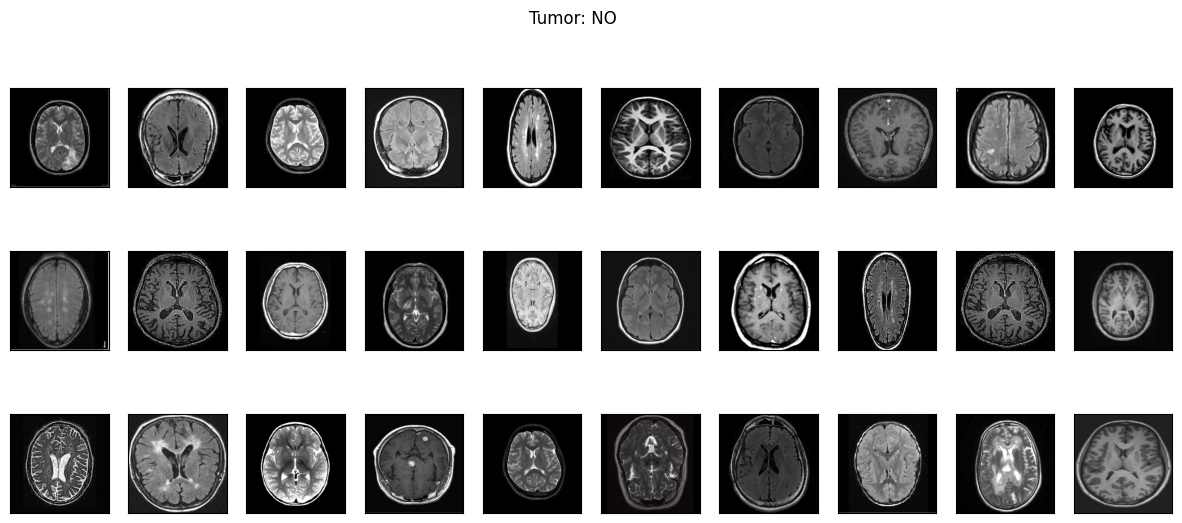

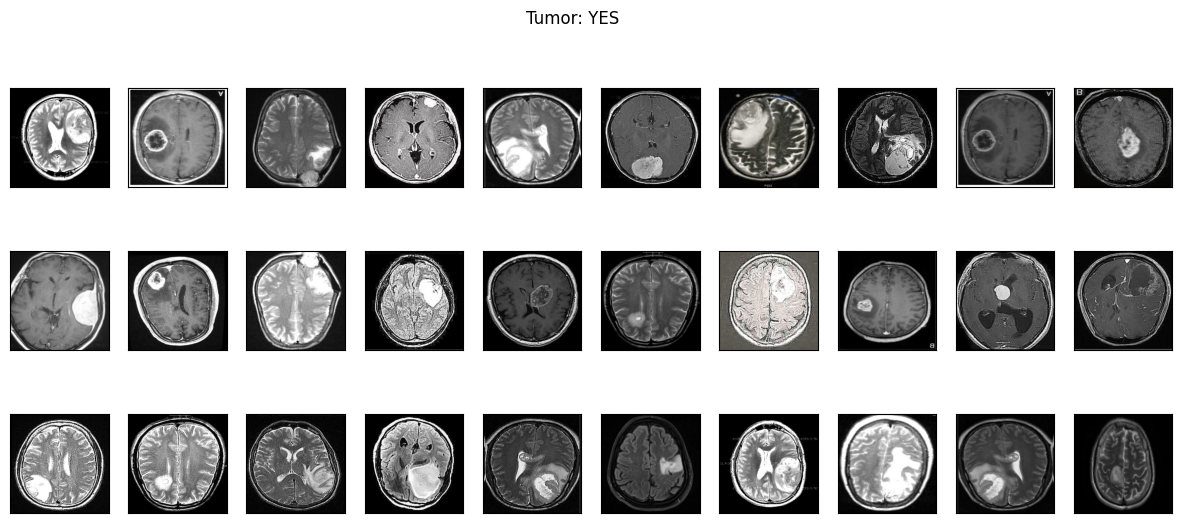

In [52]:
plot_samples(X_train, y_train, labels, 30)

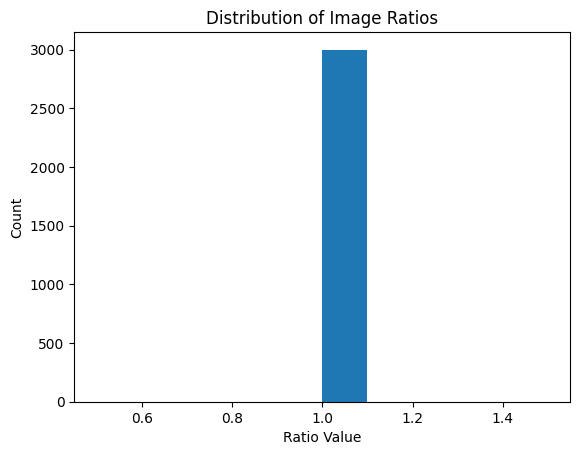

In [53]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [54]:
# def crop_imgs(set_name, add_pixels_value=0):
#     """
#     Finds the extreme points on the image and crops the rectangular out of them
#     """
#     set_new = []
#     for img in set_name:
#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         gray = cv2.GaussianBlur(gray, (5, 5), 0)

#         # threshold the image, then perform a series of erosions +
#         # dilations to remove any small regions of noise
#         thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
#         thresh = cv2.erode(thresh, None, iterations=2)
#         thresh = cv2.dilate(thresh, None, iterations=2)

#         # find contours in thresholded image, then grab the largest one
#         cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         cnts = imutils.grab_contours(cnts)
#         c = max(cnts, key=cv2.contourArea)

#         # find the extreme points
#         extLeft = tuple(c[c[:, :, 0].argmin()][0])
#         extRight = tuple(c[c[:, :, 0].argmax()][0])
#         extTop = tuple(c[c[:, :, 1].argmin()][0])
#         extBot = tuple(c[c[:, :, 1].argmax()][0])

#         ADD_PIXELS = add_pixels_value
#         new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
#         set_new.append(new_img)

#     return np.array(set_new)

def crop_imgs(set_name, add_pixels_value=0, final_size=(224,224)):
    set_new = []
    
    for img in tqdm(set_name):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        if len(cnts) == 0:
            # if no contours found, skip this image
            continue

        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        cropped = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        cropped_resized = cv2.resize(cropped, final_size, interpolation=cv2.INTER_AREA)
        set_new.append(cropped_resized)

    return np.array(set_new)


In [56]:
img = cv2.imread('./Brain_Tumor_Detection//Brain_Tumor_Detection/yes/y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

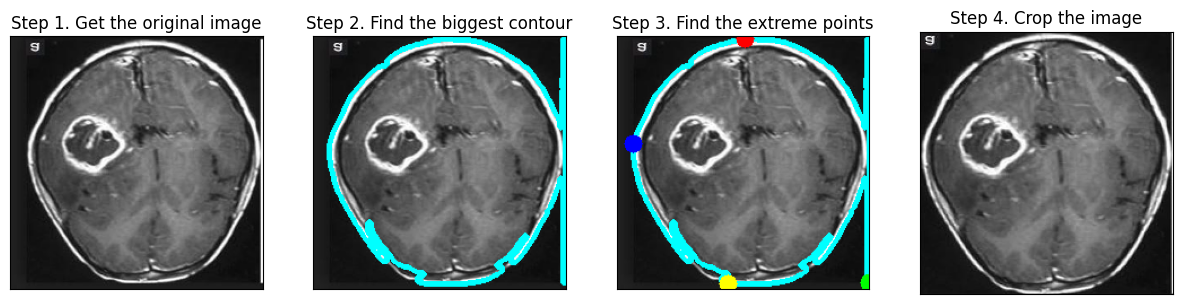

In [57]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [58]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

100%|███████████████████████████████████████| 600/600 [00:00<00:00, 5441.32it/s]


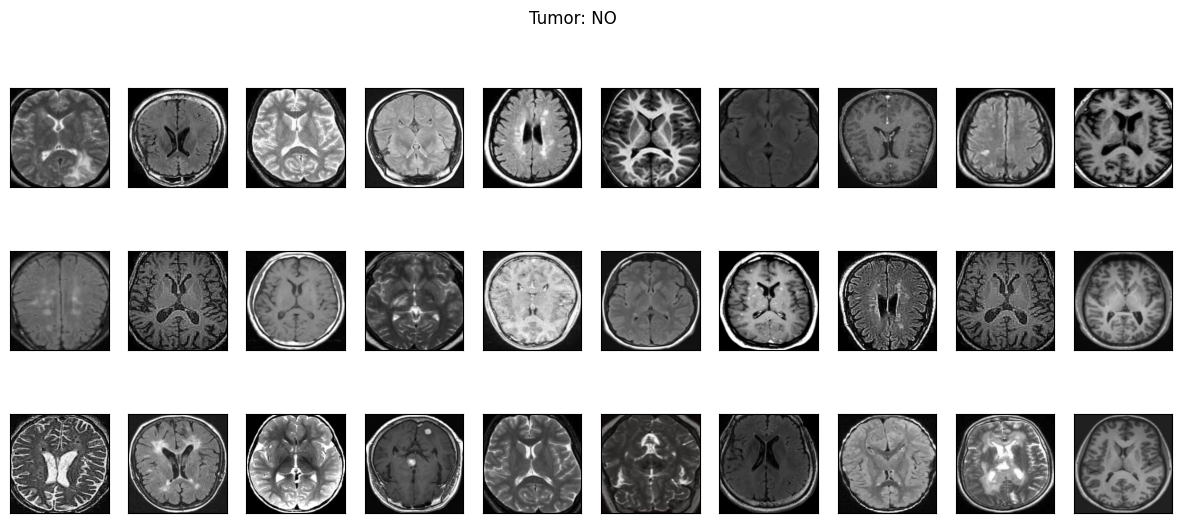

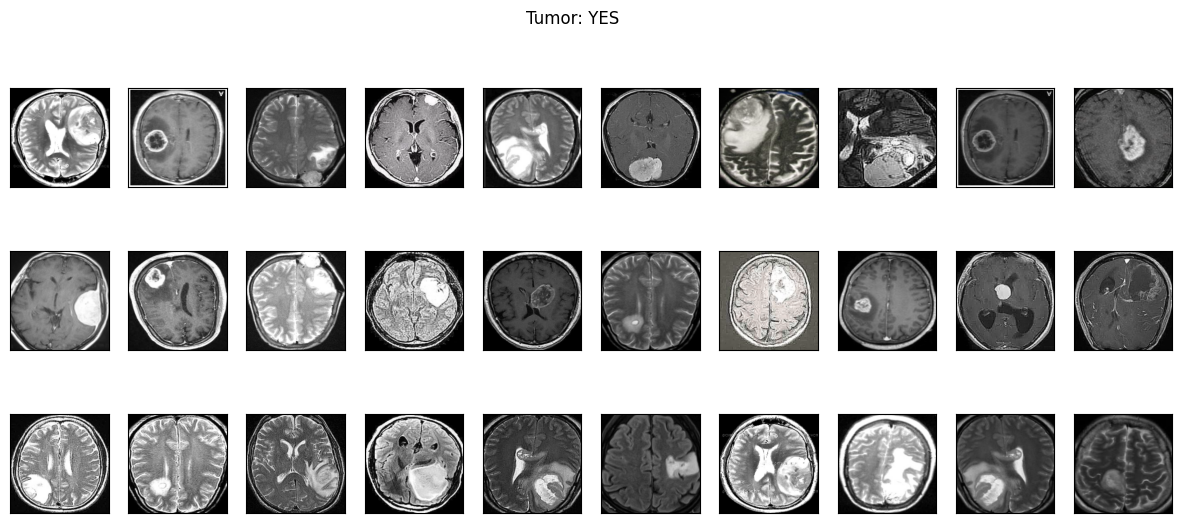

In [59]:
plot_samples(X_train_crop, y_train, labels, 30)

In [60]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [61]:
# saving new images to the folder
import os

# List of folders you want to create
folders = [
    'TRAIN_CROP/YES', 'TRAIN_CROP/NO',
    'TEST_CROP/YES', 'TEST_CROP/NO',
    'VAL_CROP/YES', 'VAL_CROP/NO'
]

# Create each folder if it doesn't exist
for folder in folders:
    os.makedirs(folder, exist_ok=True)


save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [62]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [63]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..144.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-114.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..149.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..94.061].
Clipping input data t

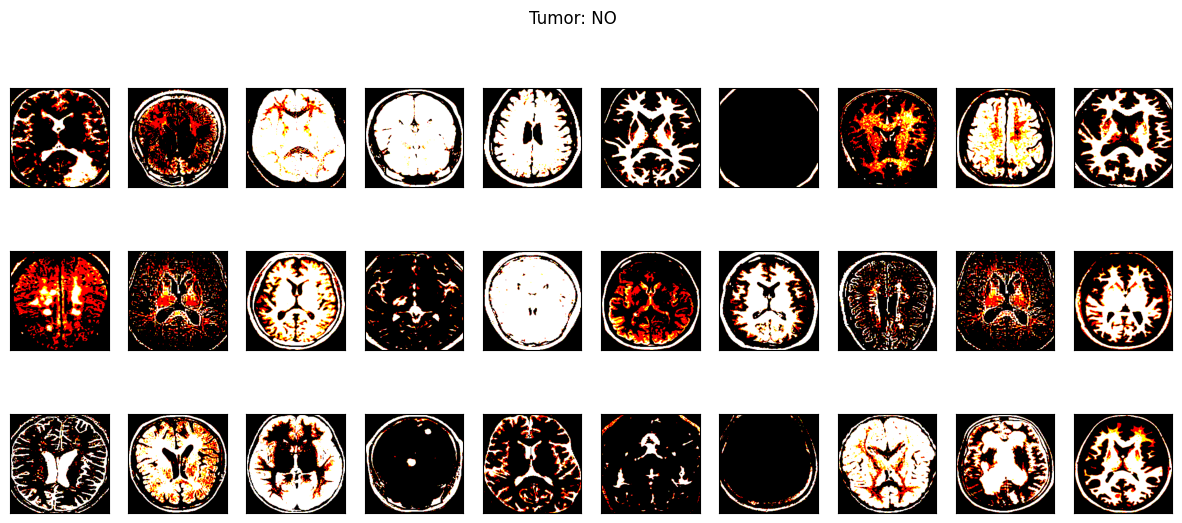

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-118.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..145.061].
Clipping input data 

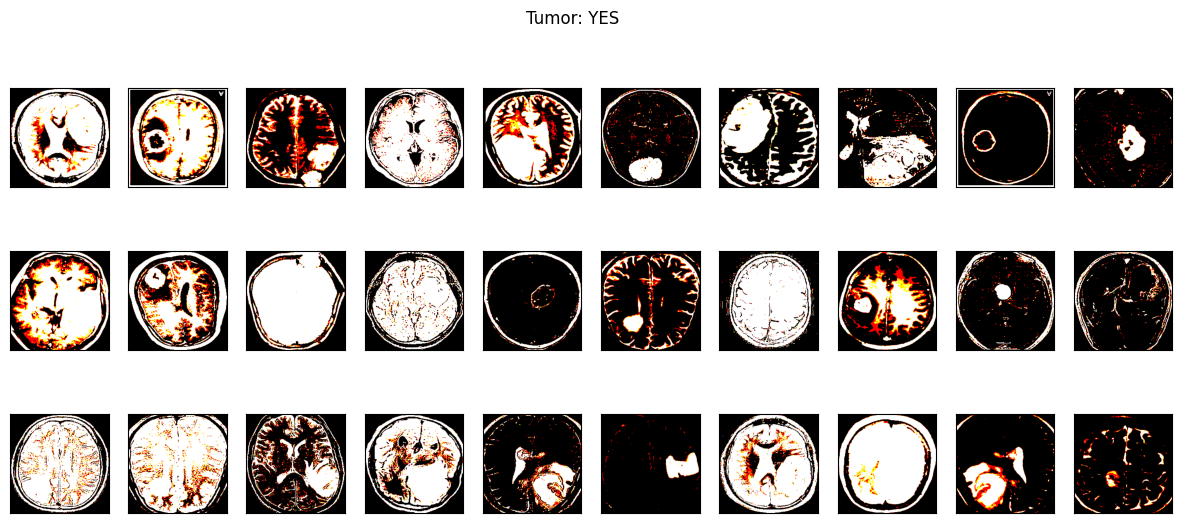

In [64]:
plot_samples(X_train_prep, y_train, labels, 30)

In [65]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [66]:
os.makedirs('preview', exist_ok=True)
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

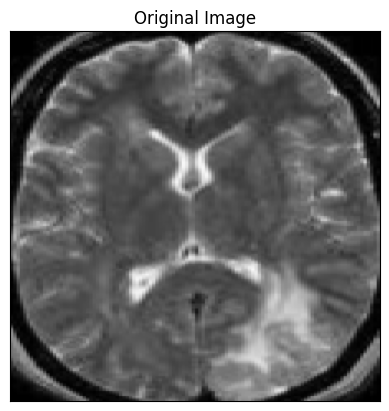

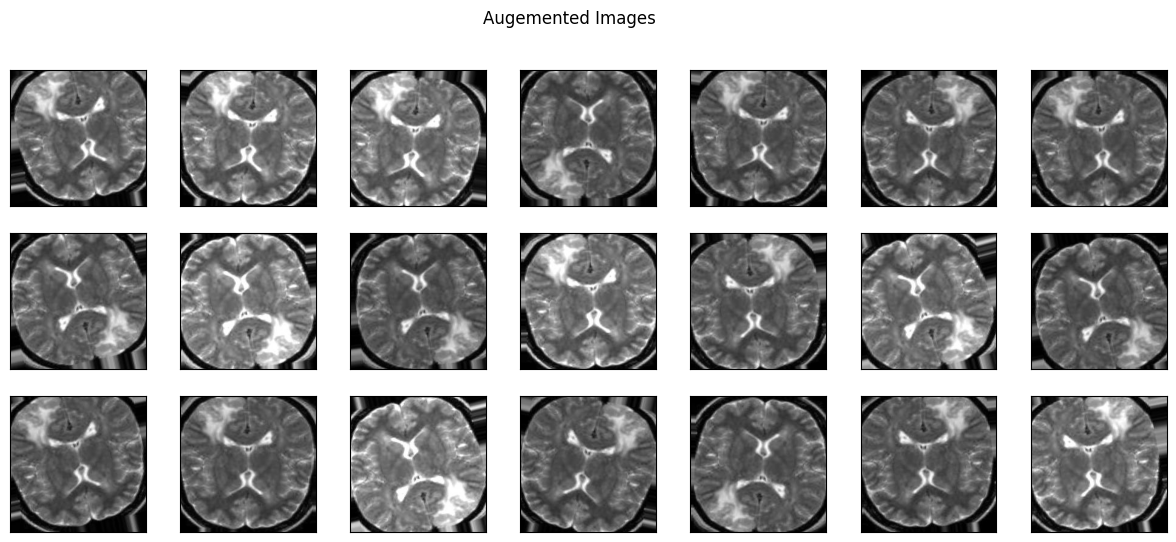

In [67]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [68]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


Found 600 images belonging to 2 classes.


<h2> Creating the model </h2>

<p> Here we will be using a pretrained DenseNet-169 model with ImageNet weights from keras. We will use transfer learning for this task. We will be using binary cross entropy as the loss function and accuracy and AUC as our monitoring metrics. </p>

In [69]:
base_Neural_Net= DenseNet169(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 81536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 81536)          │       326,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    20,873,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,843,777 (129.10 MB)

 Trainable params: 21,037,313 (80.25 MB)

 Non-trainable params: 12,806,464 (48.85 MB)

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[es]
)


/home/naveen/CS6384/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 348ms/step - AUC: 0.6598 - accuracy: 0.6260 - loss: 0.9097 - val_AUC: 0.7579 - val_accuracy: 0.5490 - val_loss: 1.7093
Epoch 2/30
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - AUC: 0.8672 - accuracy: 0.8125 - loss: 0.4360

/home/naveen/CS6384/env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8672 - accuracy: 0.8125 - loss: 0.4360 - val_AUC: 0.7625 - val_accuracy: 0.5659 - val_loss: 1.6506
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - AUC: 0.7892 - accuracy: 0.7179 - loss: 0.5789 - val_AUC: 0.8432 - val_accuracy: 0.7162 - val_loss: 0.7434
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8591 - accuracy: 0.7500 - loss: 0.4928 - val_AUC: 0.8414 - val_accuracy: 0.7162 - val_loss: 0.7397
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - AUC: 0.8395 - accuracy: 0.7556 - loss: 0.5023 - val_AUC: 0.9103 - val_accuracy: 0.8057 - val_loss: 0.3939
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8647 - accuracy: 0.7812 - loss: 0.4663 - val_AUC: 0.9125 - val_accuracy: 0.8041 - val_loss: 0.3898
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - AUC: 0.8551 - accuracy: 0.7804 - loss: 0.4840 - val_AUC: 0.9150 - val_accuracy: 0.8176 - val_loss: 0.3747
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 

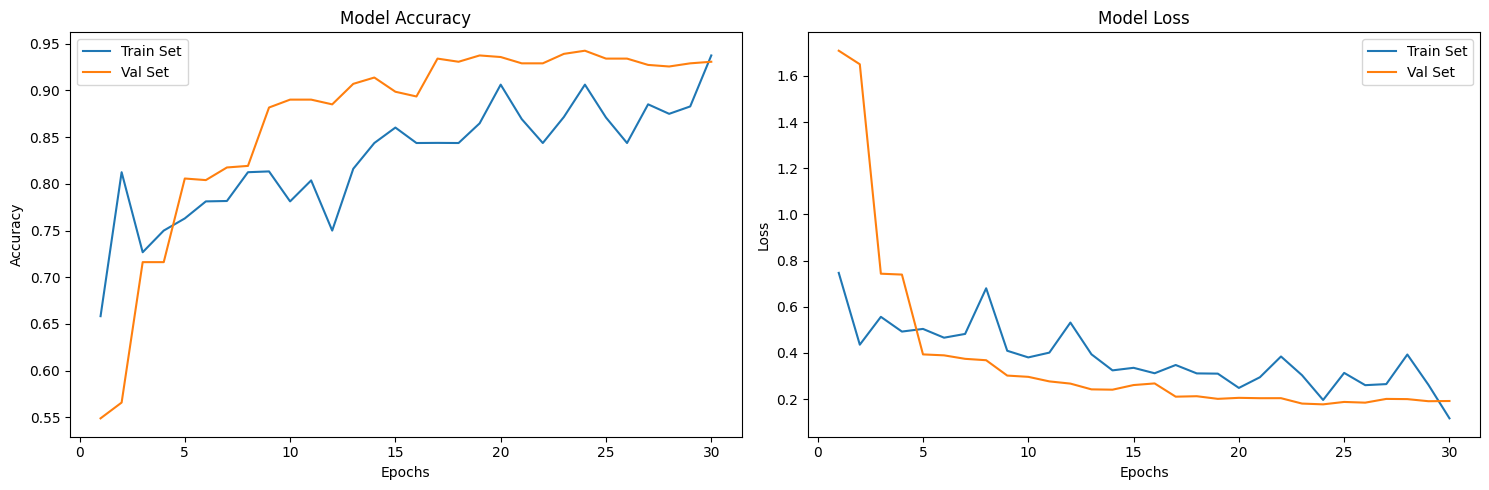

In [71]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [72]:
print(history.history.keys())


dict_keys(['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss'])


19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 478ms/step
Val Accuracy = 0.93


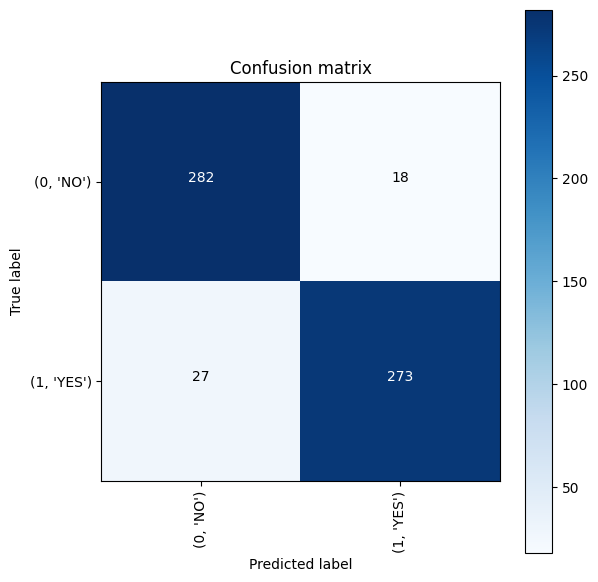

In [73]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test Accuracy = 0.92


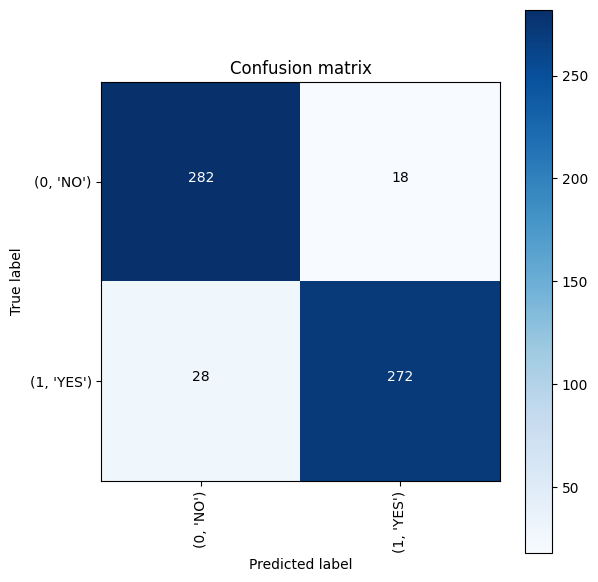

In [74]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [75]:
prob_pred = model.predict(X_test_prep)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [76]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test, predictions),4))
print('Precision score is :', np.round(metrics.precision_score(y_test, predictions, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test, predictions, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test, predictions, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, predictions),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.9233
Precision score is : 0.9238
Recall score is : 0.9233
F1 Score is : 0.9233
ROC AUC Score is : 0.9736
Cohen Kappa Score: 0.8467
		Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       300
           1       0.94      0.91      0.92       300

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600

